In [23]:
import pickle
import copy
import fiona

import alphashape as ashp
import pandas as pd
import numpy as np
import colorcet as cc
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import LineString, Polygon, Point, MultiPoint
from shapely.ops import transform, unary_union
from shapely import affinity
from descartes import PolygonPatch
from scipy.optimize import minimize
from multiprocessing import Pool
from tqdm import tqdm
from matplotlib import colors
from pyproj import Proj

In [24]:
plt.style.use('default')

In [25]:
OPT_PICKLE_PATH = '/home/yang/output/eswe/opt/'
CLS_H5_PATH = '/home/yang/output/eswe/cls/'
SM_H5_PATH = '/home/yang/output/eswe/smooth/'
OUTPUT_PATH = '/home/yang/output/eswe/esw/'
EVENT = 'jkwh'
MACHINE_IDS = ['2388', '6088']
DATE = '072016'
FIELD_ID = 'f12'
sm_log_names = ['-'.join([EVENT, mid, DATE, FIELD_ID, 'gps-sm.h5']) for mid in MACHINE_IDS]
cls_log_names = ['-'.join([EVENT, mid, DATE, FIELD_ID, 'gps-cls.h5']) for mid in MACHINE_IDS]

In [26]:
# Load the optimization results
with open(OPT_PICKLE_PATH + '-'.join([EVENT, '-'.join(MACHINE_IDS), DATE, FIELD_ID, 'opt-res.pickle']), 'rb') as fh:
    opt_res = pickle.load(fh)

In [27]:
xoff0, yoff0, xoff1, yoff1, w0, w1 = opt_res
print(xoff0, yoff0, xoff1, yoff1, w0, w1)

-1.8005729600722602 0.09928079676580083 -0.48480115454218997 0.04106873417894112 9.144 9.754


In [28]:
# Load the dataframes
gpss = {}
for mid, n1, n2 in zip(MACHINE_IDS, sm_log_names, cls_log_names):
    # Concatenate each machine's smoothed and classified data
    df_sm = pd.read_hdf(SM_H5_PATH + n1)
    df_cls = pd.read_hdf(CLS_H5_PATH + n2)
    df_concat = pd.concat([df_cls, df_sm[['xs', 'ys']]], axis=1)
    # Just like in the previous two steps, we want to group the points because there might be gaps
    # Compute time difference
    gps_seg = df_concat.copy()
    gps_seg['ts_diff'] = gps_seg['ts'].diff()
    gps_seg.loc[0, 'ts_diff'] = 0
    # A trick vector that could be used for grouping
    gps_seg['ts_diff_binary'] = gps_seg['ts_diff'] > 10
    gps_seg['ts_diff_binary_cumsum'] = gps_seg['ts_diff_binary'].apply(lambda x: 1 if x else 0).cumsum()
    # Points groups
    grp = gps_seg.groupby('ts_diff_binary_cumsum')
    # Make indices right
    gps_seg['seg_num'] = grp.ngroup()
    gps_seg.loc[0, 'seg_num'] = 0
    gps_seg = gps_seg.drop(columns=['ts_diff', 'ts_diff_binary', 'ts_diff_binary_cumsum'])
    # Add it to a dict for easy query
    gpss[mid] = gps_seg

In [29]:
d0 = gpss[MACHINE_IDS[0]]
d1 = gpss[MACHINE_IDS[1]]
d0 = d0.drop(columns=['lat', 'lon', 'alt', 'cv_prob', 'nct_prob'])
d1 = d1.drop(columns=['lat', 'lon', 'alt', 'cv_prob', 'nct_prob'])

In [30]:
pts_grps0 = [g[1] for g in d0.groupby('seg_num')]
pts_grps1 = [g[1] for g in d1.groupby('seg_num')]

In [31]:
def gen_shps(pts_grp, params):
    xoff, yoff, w = params
    # Make an copy of the points data
#     df = pts_grp[pts_grp['mode'] != 'nw-p'].copy()
#     df = df.reset_index(drop=True)
    df = pts_grp.copy()
    # Create a column for *geospatially* shifted points
    df['geom_pt_s'] = np.nan
    # Sanity check on the length of the dataframe
#     print(len(df))
    if len(df) <= 2:
#         print('Only one point in group, this should never happen')
#         print('len <= 1')
        return df
    # Shift coordinates up by one timestep
    df['xs_s'] = df['xs'].shift(-1)
    df['ys_s'] = df['ys'].shift(-1)
    # Make sure every point has a shifted coordinate
    df.loc[df.index[-1], 'xs_s'] = df.loc[df.index[-2], 'xs_s'] + 0.01
    df.loc[df.index[-1], 'ys_s'] = df.loc[df.index[-2], 'ys_s'] + 0.01
    # Create gdf from original points for processing
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['xs'], df['ys']))
    # Rename the geometry to avoid confusion
    gdf.rename_geometry('geom_pt_o', inplace=True)
    # Get the freebies (original points) from the gdf
    df['geom_pt_o'] = gdf['geom_pt_o']
    # Create linestring from original points to time-shifted points
    gdf['geom_ls_o2s'] = gdf.apply(lambda r: LineString([r['geom_pt_o'], Point(r['xs_s'], r['ys_s'])]), axis=1)
#     # HACK: if the linestring is too short, drop these rows
    gdf['geom_ls_o2s_len'] = gdf.apply(lambda r: r['geom_ls_o2s'].length, axis=1)
    gdf.loc[gdf['geom_ls_o2s_len'] < 1e-2, 'geom_ls_o2s_len'] = 1e-2
    # Scale `ls_o2s` to extend it to the right length
    # https://shapely.readthedocs.io/en/latest/manual.html#shapely.affinity.scale
    gdf['geom_ls_o2s_scaled'] = gdf.apply(lambda r: affinity.scale(r['geom_ls_o2s'], \
        xfact=abs(yoff)/r['geom_ls_o2s_len'], yfact=abs(yoff)/r['geom_ls_o2s_len'], origin=r['geom_pt_o']), axis=1)
    # Handle four cases
    if (xoff == 0) & (yoff == 0):
        # Both offsets are 0, no shift geospatially
        df['geom_pt_s'] = df['geom_pt_o']
    if (xoff != 0) & (yoff != 0):
        # Both offsets not 0, need to scale, and then parallel shift
        # Then we need to parallel shift the scaled linestring
        if xoff < 0:
            offset_dir = 'left'
            b_idx = 0
            r_idx = 1
        else:
            offset_dir = 'right'
            b_idx = 1
            r_idx = 0
        gdf['geom_ls_o2s_scaled_po'] = gdf.apply(lambda r: \
            r['geom_ls_o2s_scaled'].parallel_offset(abs(xoff), offset_dir) if r['geom_ls_o2s_scaled'].is_valid else None, axis=1)
        # Depending on the sign of yoff, we need to rotate the parallel shifted linestring
        if yoff > 0:
            rotation_angle = 360
        else:
            rotation_angle = 180
        # Rotate the line
        gdf['geom_ls_o2s_scaled_po_rot'] = gdf.apply(lambda r: affinity.rotate(r['geom_ls_o2s_scaled_po'], \
            rotation_angle, origin=r['geom_ls_o2s_scaled_po'].boundary[b_idx]) if r['geom_ls_o2s_scaled_po'] != None else None, axis=1)
        # Obtain the coordinate
        df['geom_pt_s'] = gdf.apply(lambda r: r['geom_ls_o2s_scaled_po_rot'].boundary[r_idx] if r['geom_ls_o2s_scaled_po_rot'] != None else None, axis=1)
    if (xoff == 0) & (yoff != 0):
        # Depending on the sign of yoff, we need to rotate the parallel shifted linestring
        if yoff > 0:
            rotation_angle = 360
        else:
            rotation_angle = 180
        r_idx = 1
        # Rotate the line
        gdf['geom_ls_o2s_scaled_rot'] = gdf.apply(lambda r: \
            affinity.rotate(r['geom_ls_o2s_scaled'], rotation_angle, origin=r['geom_pt_o']) if r['geom_ls_o2s_scaled'].is_valid else None, axis=1)
        # xoff is 0, so we need to get the right linestring by scaling the linestring, then get the endpoint with no parallel shift
        df['geom_pt_s'] = gdf.apply(lambda r: r['geom_ls_o2s_scaled_rot'].boundary[r_idx] if r['geom_ls_o2s_scaled_rot'] != None else None, axis=1)
    if (xoff != 0) & (yoff == 0):
        # yoff is 0, so we need the get the linestring, no scaling, just parallel shift
        if xoff < 0:
            offset_dir = 'left'
            b_idx = 0
        else:
            offset_dir = 'right'
            b_idx = 1
        gdf['geom_ls_o2s_scaled_po'] = gdf.apply(lambda r: \
            r['geom_ls_o2s'].parallel_offset(abs(xoff), offset_dir) if r['geom_ls_o2s'].is_valid else None, axis=1)
        df['geom_pt_s'] = gdf.apply(lambda r: r['geom_ls_o2s_scaled_po'].boundary[b_idx] if r['geom_ls_o2s_scaled_po'] != None else None, axis=1)
            
    # Let's generate the shapes now
    df_shp = df.copy()
    df_shp = df_shp.dropna(subset=['geom_pt_s']).reset_index(drop=True)
    # Shift the points up by one timestep
    df_shp['geom_pt_s_s'] = df_shp['geom_pt_s'].shift(-1)
    # Create linestrings by connecting the paths
    df_shp = df_shp.iloc[:-2].copy()
    df_shp['geom_ls_path'] = df_shp.apply(lambda r: LineString([r['geom_pt_s'], r['geom_pt_s_s']]) if (r['geom_pt_s'] != None) & (r['geom_pt_s_s'] != None) else None, axis=1)
    # Extend the each path to left/right to obtain header edge points
    geom_ls_path_gs = gpd.GeoSeries(df_shp['geom_ls_path'])
    df_shp['geom_pt_edge_l'] = geom_ls_path_gs.apply(lambda r: r.parallel_offset(w / 2, 'left').boundary[1] if (r.length > 1e-5) else np.nan)
    df_shp['geom_pt_edge_r'] = geom_ls_path_gs.apply(lambda r: r.parallel_offset(w / 2, 'right').boundary[0] if (r.length > 1e-5) else np.nan)
    # Create dataframe to line these points up
    df_edge_pts = pd.concat([df_shp['geom_pt_edge_l'].rename('l'), df_shp['geom_pt_edge_l'].shift(-1).rename('ls'), \
                             df_shp['geom_pt_edge_r'].shift(-1).rename('rs'), df_shp['geom_pt_edge_r'].rename('r')], axis=1)
    # Drop the last one since it will be nan
    df_edge_pts = df_edge_pts.drop(index=[df_edge_pts.index[-1]])
    # Sometimes this happens and we don't have any polygons
    if len(df_edge_pts) == 0:
        return df_shp
    # Create these polygons and swath lines
    df_shp['geom_poly_cvg'] = df_edge_pts.apply(lambda r: Polygon([r['l'], r['ls'], r['rs'], r['r']]).convex_hull \
                                                if (r['l'] != None) & (r['ls'] != None) & (r['rs'] != None) & (r['r'] != None) else None, axis=1)
    df_shp['geom_ls_swath'] = df_edge_pts.apply(lambda r: LineString([r['l'], r['r']]) if (r['l'] != None) & (r['r'] != None) else None, axis=1)
    # Check discontiuities
#     poly_cvg = gpd.GeoSeries(df_shp['geom_poly_cvg'])
#     df_shp = df_shp.drop(index=poly_cvg[poly_cvg.area > 50].index).reset_index(drop=True)
        
    return df_shp

In [32]:
# def gen_shps(pts_grp, params):
#     xoff, yoff, w = params
#     # Make an copy of the points data
# #     df = pts_grp[pts_grp['mode'] == 'w'].copy()
#     df = pts_grp.copy()
# #     df = df.reset_index(drop=True)
#     # Create a column for *geospatially* shifted points
#     df['geom_pt_s'] = np.nan
#     # Sanity check on the length of the dataframe
#     if len(df) <= 1:
# #         print('Only one point in group, this should never happen')
#         return df
#     # Shift coordinates up by one timestep
#     df['xs_s'] = df['xs'].shift(-1)
#     df['ys_s'] = df['ys'].shift(-1)
#     # Make sure every point has a shifted coordinate
#     df.loc[df.index[-1], 'xs_s'] = df.loc[df.index[-2], 'xs_s'] + 0.01
#     df.loc[df.index[-1], 'ys_s'] = df.loc[df.index[-2], 'ys_s'] + 0.01
#     # Create gdf from original points for processing
#     gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['xs'], df['ys']))
#     # Rename the geometry to avoid confusion
#     gdf.rename_geometry('geom_pt_o', inplace=True)
#     # Get the freebies (original points) from the gdf
#     df['geom_pt_o'] = gdf['geom_pt_o']
#   # Create linestring from original points to time-shifted points
#     gdf['geom_ls_o2s'] = gdf.apply(lambda r: LineString([r['geom_pt_o'], Point(r['xs_s'], r['ys_s'])]), axis=1)
#     # Scale `ls_o2s` to extend it to the right length
#     # https://shapely.readthedocs.io/en/latest/manual.html#shapely.affinity.scale
#     gdf['geom_ls_o2s_scaled'] = gdf.apply(lambda r: affinity.scale(r['geom_ls_o2s'], \
#         xfact=abs(yoff)/r['geom_ls_o2s'].length, yfact=abs(yoff)/r['geom_ls_o2s'].length, origin=r['geom_pt_o']), axis=1)
#     # Handle four cases
#     if (xoff == 0) & (yoff == 0):
#         # Both offsets are 0, no shift geospatially
#         df['geom_pt_s'] = df['geom_pt_o']
#     if (xoff != 0) & (yoff != 0):
#         # Both offsets not 0, need to scale, and then parallel shift
#         # Then we need to parallel shift the scaled linestring
#         if xoff < 0:
#             offset_dir = 'left'
#             b_idx = 0
#             r_idx = 1
#         else:
#             offset_dir = 'right'
#             b_idx = 1
#             r_idx = 0
#         gdf['geom_ls_o2s_scaled_po'] = gdf.apply(lambda r: r['geom_ls_o2s_scaled'].parallel_offset(abs(xoff), offset_dir), axis=1)
#         # Depending on the sign of yoff, we need to rotate the parallel shifted linestring
#         if yoff > 0:
#             rotation_angle = 360
#         else:
#             rotation_angle = 180
#         # Rotate the line
#         gdf['geom_ls_o2s_scaled_po_rot'] = gdf.apply(lambda r: affinity.rotate(r['geom_ls_o2s_scaled_po'], \
#             rotation_angle, origin=r['geom_ls_o2s_scaled_po'].boundary[b_idx]), axis=1)
#         # Obtain the coordinate
#         df['geom_pt_s'] = gdf.apply(lambda r: r['geom_ls_o2s_scaled_po_rot'].boundary[r_idx], axis=1)
#     if (xoff == 0) & (yoff != 0):
#         # Depending on the sign of yoff, we need to rotate the parallel shifted linestring
#         if yoff > 0:
#             rotation_angle = 360
#         else:
#             rotation_angle = 180
#         r_idx = 1
#         # Rotate the line
#         gdf['geom_ls_o2s_scaled_rot'] = gdf.apply(lambda r: affinity.rotate(r['geom_ls_o2s_scaled'], rotation_angle, origin=r['geom_pt_o']), axis=1)
#         # xoff is 0, so we need to get the right linestring by scaling the linestring, then get the endpoint with no parallel shift
#         df['geom_pt_s'] = gdf.apply(lambda r: r['geom_ls_o2s_scaled_rot'].boundary[r_idx], axis=1)
#     if (xoff != 0) & (yoff == 0):
#         # yoff is 0, so we need the get the linestring, no scaling, just parallel shift
#         if xoff < 0:
#             offset_dir = 'left'
#             b_idx = 0
#         else:
#             offset_dir = 'right'
#             b_idx = 1
#         gdf['geom_ls_o2s_scaled_po'] = gdf.apply(lambda r: r['geom_ls_o2s'].parallel_offset(abs(xoff), offset_dir), axis=1)
#         df['geom_pt_s'] = gdf.apply(lambda r: r['geom_ls_o2s_scaled_po'].boundary[b_idx], axis=1)
    
#     # Let's generate the shapes now
#     df_shp = df.copy()
#     # Shift the points up by one timestep
#     df_shp['geom_pt_s_s'] = df_shp['geom_pt_s'].shift(-1)
#     # Create linestrings by connecting the paths
#     df_shp = df_shp.iloc[:-2].copy()
#     df_shp['geom_ls_path'] = df_shp.apply(lambda r: LineString([r['geom_pt_s'], r['geom_pt_s_s']]), axis=1)
#     # Extend the each path to left/right to obtain header edge points
#     geom_ls_path_gs = gpd.GeoSeries(df_shp['geom_ls_path'])
#     df_shp['geom_pt_edge_l'] = geom_ls_path_gs.apply(lambda r: r.parallel_offset(w / 2, 'left').boundary[1] if (r.length > 1e-5) else np.nan)
#     df_shp['geom_pt_edge_r'] = geom_ls_path_gs.apply(lambda r: r.parallel_offset(w / 2, 'right').boundary[0] if (r.length > 1e-5) else np.nan)
#     # Create dataframe to line these points up
#     df_edge_pts = pd.concat([df_shp['geom_pt_edge_l'].rename('l'), df_shp['geom_pt_edge_l'].shift(-1).rename('ls'), \
#                              df_shp['geom_pt_edge_r'].shift(-1).rename('rs'), df_shp['geom_pt_edge_r'].rename('r')], axis=1)
#     # Drop the last one since it will be nan
#     df_edge_pts = df_edge_pts.drop(index=[df_edge_pts.index[-1]])
#     # Sometimes this happens and we don't have any polygons
#     if len(df_edge_pts) == 0:
#         return df_shp
#     # Create these polygons and swath lines
#     df_shp['geom_poly_cvg'] = df_edge_pts.apply(lambda r: Polygon([r['l'], r['ls'], r['rs'], r['r']]).convex_hull \
#                                                 if (r['l'] != None) & (r['ls'] != None) & (r['rs'] != None) & (r['r'] != None) else None, axis=1)
#     df_shp['geom_ls_swath'] = df_edge_pts.apply(lambda r: LineString([r['l'], r['r']]) if (r['l'] != None) & (r['r'] != None) else None, axis=1)
#     # Check discontiuities
# #     poly_cvg = gpd.GeoSeries(df_shp['geom_poly_cvg'])
# #     df_shp_f = df_shp.drop(index=poly_cvg[poly_cvg.area > 20].index).reset_index(drop=True)
        
#     return df_shp

In [33]:
# Obtain coverage polygons and swath linestrings
p = Pool(15)
res0 = [p.apply_async(gen_shps, args=(g, [xoff0,yoff0,w0])) for g in pts_grps0]
res1 = [p.apply_async(gen_shps, args=(g, [xoff1,yoff1,w1])) for g in pts_grps1]
p.close()
p.join()
p.terminate()
# Concatenate all the dataframes within the group
shps0 = pd.concat([r.get() for r in res0])
shps1 = pd.concat([r.get() for r in res1])

In [34]:
shps0 = shps0.reset_index(drop=True)
shps1 = shps1.reset_index(drop=True)

In [171]:
# Get the linestrings and coverage polygons for each machine
ls0 = gpd.GeoSeries(shps0['geom_ls_swath'])
ls1 = gpd.GeoSeries(shps1['geom_ls_swath'])
poly0 = gpd.GeoSeries(shps0['geom_poly_cvg'])
poly1 = gpd.GeoSeries(shps1['geom_poly_cvg'])

In [172]:
esw0 = []
for idx, l in tqdm(ls0.iteritems()):
    w = w0
    if l == None:
        esw0.append(w)
        continue
    # Find if there is any past coverage polygon from the *same machine* that intersects with
    # a particular swath line
    l_int_shps0 = (shps0.loc[poly0.intersects(l) == True, 'ts'] < (shps0.loc[idx, 'ts']-1))
    # There can be intersections but we only want intersections from past polygons
    l_f = l_int_shps0[l_int_shps0 == True]
    l_f = l_f[shps0.loc[l_f.index, 'mode'] == 'w']
    # If there is, substract the overlap part
    if len(l_f):
        w -= gpd.GeoSeries(shps0.loc[l_f.index, 'geom_poly_cvg']).unary_union.intersection(l).length
        if w < 0:
            w = 0
    else:
        # Otherwise, don't do anything
        pass
    
    # For the same swath line, find if there is any past coverage polygon from the *different machine*
    # that intersects with a particular swath line
    l_int_shps1 = (shps1.loc[poly1.intersects(l) == True, 'ts'] < (shps0.loc[idx, 'ts']-1))
    # There can be intersections but we only want intersections from past polygons
    l_f = l_int_shps1[l_int_shps1 == True]
    l_f = l_f[shps1.loc[l_f.index, 'mode'] == 'w']
    # If there is, substract the overlap part
    if len(l_f):
        w -= gpd.GeoSeries(shps1.loc[l_f.index, 'geom_poly_cvg']).unary_union.intersection(l).length
        if w < 0:
            w = 0
    else:
        # Otherwise, don't do anything
        pass
    
    esw0.append(w)

24795it [03:34, 115.58it/s]


In [173]:
esw1 = []
for idx, l in tqdm(ls1.iteritems()):
    w = w1
    if l == None:
        esw1.append(w1)
        continue
    # Find if there is any past coverage polygon from the *same machine* that intersects with
    # a particular swath line
    l_int_shps1 = (shps1.loc[poly1.intersects(l) == True, 'ts'] < (shps1.loc[idx, 'ts']-1))
    # There can be intersections but we only want intersections from past polygons
    l_f = l_int_shps1[l_int_shps1 == True]
    l_f = l_f[shps1.loc[l_f.index, 'mode'] == 'w']
    # If there is, substract the overlap part
    if len(l_f):
        w -= gpd.GeoSeries(shps1.loc[l_f.index, 'geom_poly_cvg']).unary_union.intersection(l).length
        if w < 0:
            w = 0
    else:
        # Otherwise, don't do anything
        pass
    
    # For the same swath line, find if there is any past coverage polygon from the *different machine*
    # that intersects with a particular swath line
    l_int_shps0 = (shps0.loc[poly0.intersects(l) == True, 'ts'] < (shps1.loc[idx, 'ts']-1))
    # There can be intersections but we only want intersections from past polygons
    l_f = l_int_shps0[l_int_shps0 == True]
    l_f = l_f[shps0.loc[l_f.index, 'mode'] == 'w']
    # If there is, substract the overlap part
    if len(l_f):
        w -= gpd.GeoSeries(shps0.loc[l_f.index, 'geom_poly_cvg']).unary_union.intersection(l).length
        if w < 0:
            w = 0
    else:
        # Otherwise, don't do anything
        pass
    
    esw1.append(w)

37992it [05:18, 119.33it/s]


In [174]:
shps0['esw'] = esw0
shps1['esw'] = esw1

(725645.8765397011, 726135.5542250405, 4517530.2660757685, 4519292.48395162)

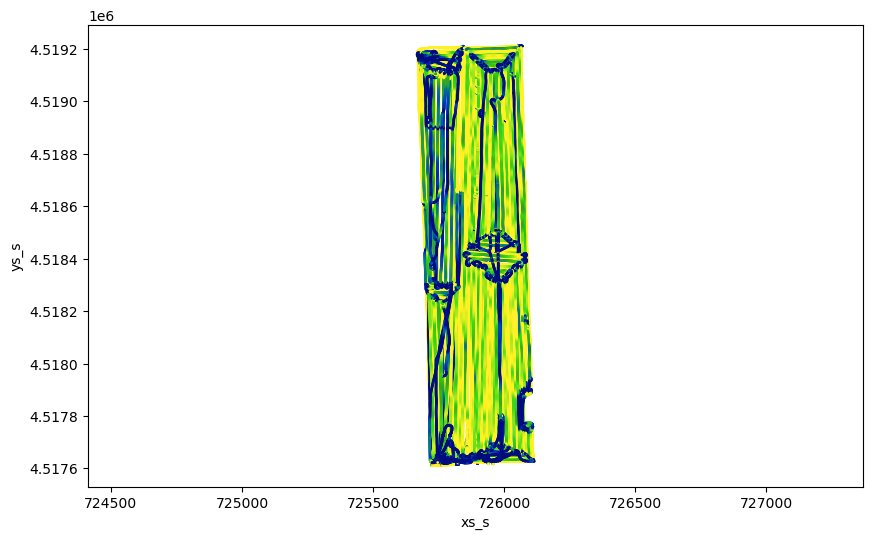

In [175]:
fig, ax = plt.subplots(figsize=(10,6))
shps0.plot.scatter(x='xs_s', y='ys_s', c='esw', s=1, cmap=cc.cm.bgy, colorbar=False, ax=ax)
shps1.plot.scatter(x='xs_s', y='ys_s', c='esw', s=1, cmap=cc.cm.bgy, colorbar=False, ax=ax)
ax.axis('equal')

In [176]:
print(shps0['esw'].mean(), shps1['esw'].mean())

5.693015866979683 6.222389232147215


In [177]:
print(shps0.loc[shps0['mode'] == 'w', 'esw'].mean(), shps1.loc[shps1['mode'] == 'w', 'esw'].mean())

7.718165399424117 7.499372938470035


In [178]:
print(np.mean(shps0['esw'] / w0), shps1['esw'].mean() / w1)

0.5836596131822517 0.6379320516862022


In [179]:
shps0.to_pickle(OUTPUT_PATH + '-'.join([EVENT, MACHINE_IDS[0], DATE, FIELD_ID, 'gps-esw.pickle']))
shps1.to_pickle(OUTPUT_PATH + '-'.join([EVENT, MACHINE_IDS[1], DATE, FIELD_ID, 'gps-esw.pickle']))